In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [7]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.rand(num_inputs,num_hiddens)*sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [23]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

In [10]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [11]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

# RNN-based Language Model

In [12]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

In [13]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [14]:
@d2l.add_to_class(RNNLMScratch)  #@save
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

In [15]:
@d2l.add_to_class(RNNLMScratch)  #@save
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)  #@save
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

In [16]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

#  Gradient Clipping

In [17]:
@d2l.add_to_class(d2l.Trainer)  #@save
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

# Training 

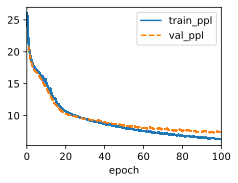

In [18]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

# Decoding

In [29]:
@d2l.add_to_class(RNNLMScratch)  #@save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    print(vocab[prefix[0]])
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [30]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

10


'it has and the the the the'

# Tóm tắt

- Mô hình chuỗi cần khởi tạo trạng thái cho quá trình huấn luyện.
- Giữa các mô hình chuỗi, ta cần đảm bảo tách gradient để chắc chắn rằng phép tính vi phân tự động không ảnh hưởng ra ngoài phạm vi mẫu hiện tại.
- Mô hình ngôn ngữ RNN đơn giản bao gồm một bộ mã hóa, một mô hình RNN và một bộ giải mã.
- Gọt gradient có thể hạn chế sự bùng nổ gradient nhưng không thể khắc phục được vấn đề tiêu biến gradient.
- Perplexity đánh giá chất lượng mô hình trên các chuỗi có độ dài khác nhau, được tính bằng trung bình lũy thừa của mất mát entropy chéo.
- Phân tách tuần tự cho kết quả mô hình tốt hơn.